- Feature Engineering: Data cleaning process
- Summary:
    - Clean session data
    - Clean training/testing data set: (Using ONE HOT ENCODING(pd.get_dummies) for assigning values to categorical features-- see tfa_wd [pd.getdummies] for example)
        - manipulate date/time data- format, feature extraction from date/time data (one hot encoding)- Extract Yr,Month,Date,Weekday,Season
        - manipulate Age data
        - manipulate Categorical feature data (one hot encoding)
    - Merge cleaned Training/Testing dataset with cleaned Session dataset
    - Split cleaned training/testing dataset; Save files to csv.

In [6]:
# Some of the code refered from: https://www.kaggle.com/svpons/feature-engineering

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
#import pickle
import datetime
from datetime import date
#import os
import seaborn as sns
from sklearn.preprocessing import *
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import StratifiedShuffleSplit
import seaborn as sns
%matplotlib inline

C:\Users\haiha\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Cleaning Session Data

In [8]:
df_sessions = pd.read_csv('sessions.csv')
df_sessions['id'] = df_sessions['user_id']
df_sessions = df_sessions.drop(['user_id'],axis=1)

In [9]:
df_sessions.head(20)

,action,action_type,action_detail,device_type,secs_elapsed,id
0,lookup,NaN,NaN,Windows Desktop,319.0,d1mm9tcy42
1,search_results,click,view_search_results,Windows Desktop,67753.0,d1mm9tcy42
2,lookup,NaN,NaN,Windows Desktop,301.0,d1mm9tcy42
3,search_results,click,view_search_results,Windows Desktop,22141.0,d1mm9tcy42
4,lookup,NaN,NaN,Windows Desktop,957.0,jpmpj40cvk
5,search_results,click,view_search_results,Windows Desktop,965.0,jpmpj40cvk
6,search_results,click,view_search_results,Windows Desktop,1021.0,jpmpj40cvk
7,search_results,click,view_search_results,Windows Desktop,938.0,jpmpj40cvk
8,search_results,click,view_search_results,Windows Desktop,2702.0,jpmpj40cvk
9,ajax_refresh_subtotal,click,change_trip_characteristics,Windows Desktop,674.0,jpmpj40cvk


In [10]:
df_sessions.shape # observe: the size of the session is much larger than training set. 
                # that is because every row on session is one action, Each row on training set is for one person. 
                # Each user can have multiple actions. 
# Thinking: how to groupby session data and training set? (union or intersect?)

(1048575, 6)

In [11]:
df_sessions.isnull().sum() # we need to make all NAN, NONE,... a unique value, e.g. make them all=NAN to keep consistency(as below)

action             7873
action_type      143097
action_detail    143097
device_type           0
secs_elapsed      11067
id                 2797
dtype: int64

##### Preparing Session data

- Filling nan with value ('NAN'), make null, na, nan, NAN to 'NAN'

In [12]:
print('Working on Session data...')
#Filling nan with value ('NAN')
df_sessions.action = df_sessions.action.fillna('NAN')
df_sessions.action_type = df_sessions.action_type.fillna('NAN')
df_sessions.action_detail = df_sessions.action_detail.fillna('NAN')
df_sessions.device_type = df_sessions.device_type.fillna('NAN')

Working on Session data...


- Group low frequency actions to 'Other'

In [13]:
df_sessions.action.head(10)

0                   lookup
1           search_results
2                   lookup
3           search_results
4                   lookup
5           search_results
6           search_results
7           search_results
8           search_results
9    ajax_refresh_subtotal
Name: action, dtype: object

In [14]:
df_sessions.action.value_counts() # we observe many low frequency(small #count) actions at bottom that can be grouped together. 

show                               209655
search_results                     109430
personalize                        105718
lookup                              88302
ajax_refresh_subtotal               71482
index                               69441
similar_listings                    53814
update                              38829
search                              26520
header_userpic                      17332
create                              17262
track_page_view                     17089
active                              15855
social_connections                  15301
collections                         12763
dashboard                            9535
calendar_tab_inner2                  9353
ajax_check_dates                     8387
NAN                                  7873
edit                                 7716
confirm_email                        7424
ask_question                         6994
requested                            6242
authenticate                      

In [15]:
#create a dictionary to relate the action item and its count, using zip() function
#method 1: act = dict(zip(df_sessions.action.value_counts().index,df_sessions.action.value_counts().values))

In [16]:
#method 2:
np.unique(df_sessions.action, return_counts=True) #[array1,array2] where array1=unique action item; array2=count

(array(['10', '11', '12', '15', 'NAN', 'about_us', 'account', 'active',
        'add_guests', 'add_note', 'airbnb_picks', 'ajax_check_dates',
        'ajax_get_referrals_amt', 'ajax_get_results',
        'ajax_google_translate', 'ajax_google_translate_description',
        'ajax_google_translate_reviews', 'ajax_image_upload',
        'ajax_lwlb_contact', 'ajax_payout_edit',
        'ajax_payout_options_by_country', 'ajax_photo_widget',
        'ajax_photo_widget_form_iframe', 'ajax_price_and_availability',
        'ajax_refresh_subtotal', 'ajax_send_message', 'ajax_statsd',
        'ajax_worth', 'apply', 'apply_code', 'apply_reservation',
        'ask_question', 'at_checkpoint', 'authenticate', 'authorize',
        'available', 'badge', 'become_user', 'calendar_tab_inner2',
        'callback', 'campaigns', 'cancel', 'cancellation_policies',
        'change', 'change_availability', 'change_currency',
        'change_default_payout', 'change_password', 'city_count',
        'clear_reserv

In [17]:
list(zip(np.unique(df_sessions.action, return_counts=True)))

[(array(['10', '11', '12', '15', 'NAN', 'about_us', 'account', 'active',
         'add_guests', 'add_note', 'airbnb_picks', 'ajax_check_dates',
         'ajax_get_referrals_amt', 'ajax_get_results',
         'ajax_google_translate', 'ajax_google_translate_description',
         'ajax_google_translate_reviews', 'ajax_image_upload',
         'ajax_lwlb_contact', 'ajax_payout_edit',
         'ajax_payout_options_by_country', 'ajax_photo_widget',
         'ajax_photo_widget_form_iframe', 'ajax_price_and_availability',
         'ajax_refresh_subtotal', 'ajax_send_message', 'ajax_statsd',
         'ajax_worth', 'apply', 'apply_code', 'apply_reservation',
         'ask_question', 'at_checkpoint', 'authenticate', 'authorize',
         'available', 'badge', 'become_user', 'calendar_tab_inner2',
         'callback', 'campaigns', 'cancel', 'cancellation_policies',
         'change', 'change_availability', 'change_currency',
         'change_default_payout', 'change_password', 'city_count',
      

In [18]:
#Action values with low frequency(here <100) are changed to 'OTHER'

act_freq = 100  #Threshold of frequency
act = dict(zip(*np.unique(df_sessions.action, return_counts=True)))
act

{'10': 200,
 '11': 36,
 '12': 282,
 '15': 95,
 'NAN': 7873,
 'about_us': 10,
 'account': 1112,
 'active': 15855,
 'add_guests': 13,
 'add_note': 161,
 'airbnb_picks': 29,
 'ajax_check_dates': 8387,
 'ajax_get_referrals_amt': 557,
 'ajax_get_results': 88,
 'ajax_google_translate': 18,
 'ajax_google_translate_description': 74,
 'ajax_google_translate_reviews': 11,
 'ajax_image_upload': 1560,
 'ajax_lwlb_contact': 5042,
 'ajax_payout_edit': 103,
 'ajax_payout_options_by_country': 115,
 'ajax_photo_widget': 4,
 'ajax_photo_widget_form_iframe': 2424,
 'ajax_price_and_availability': 26,
 'ajax_refresh_subtotal': 71482,
 'ajax_send_message': 5,
 'ajax_statsd': 307,
 'ajax_worth': 12,
 'apply': 5,
 'apply_code': 6,
 'apply_reservation': 1272,
 'ask_question': 6994,
 'at_checkpoint': 497,
 'authenticate': 6021,
 'authorize': 127,
 'available': 717,
 'badge': 14,
 'become_user': 7,
 'calendar_tab_inner2': 9353,
 'callback': 888,
 'campaigns': 2943,
 'cancel': 52,
 'cancellation_policies': 1592,


In [19]:
df_sessions.action.apply?
# series.apply(function) will apply a function to the values(actions item) of the series(df_sessions.action)

In [20]:
df_sessions.action = df_sessions.action.apply(lambda x: 'OTHER' if act[x] < act_freq else x) #note: act will not be changed
                                                                                # df_sessions.action will be reassigned
df_sessions.action.value_counts() # action items with count<100 has been removed 

show                              209655
search_results                    109430
personalize                       105718
lookup                             88302
ajax_refresh_subtotal              71482
index                              69441
similar_listings                   53814
update                             38829
search                             26520
header_userpic                     17332
create                             17262
track_page_view                    17089
active                             15855
social_connections                 15301
collections                        12763
dashboard                           9535
calendar_tab_inner2                 9353
ajax_check_dates                    8387
NAN                                 7873
edit                                7716
confirm_email                       7424
ask_question                        6994
requested                           6242
authenticate                        6021
other_hosting_re

In [21]:
act #not changed. 

{'10': 200,
 '11': 36,
 '12': 282,
 '15': 95,
 'NAN': 7873,
 'about_us': 10,
 'account': 1112,
 'active': 15855,
 'add_guests': 13,
 'add_note': 161,
 'airbnb_picks': 29,
 'ajax_check_dates': 8387,
 'ajax_get_referrals_amt': 557,
 'ajax_get_results': 88,
 'ajax_google_translate': 18,
 'ajax_google_translate_description': 74,
 'ajax_google_translate_reviews': 11,
 'ajax_image_upload': 1560,
 'ajax_lwlb_contact': 5042,
 'ajax_payout_edit': 103,
 'ajax_payout_options_by_country': 115,
 'ajax_photo_widget': 4,
 'ajax_photo_widget_form_iframe': 2424,
 'ajax_price_and_availability': 26,
 'ajax_refresh_subtotal': 71482,
 'ajax_send_message': 5,
 'ajax_statsd': 307,
 'ajax_worth': 12,
 'apply': 5,
 'apply_code': 6,
 'apply_reservation': 1272,
 'ask_question': 6994,
 'at_checkpoint': 497,
 'authenticate': 6021,
 'authorize': 127,
 'available': 717,
 'badge': 14,
 'become_user': 7,
 'calendar_tab_inner2': 9353,
 'callback': 888,
 'campaigns': 2943,
 'cancel': 52,
 'cancellation_policies': 1592,


#### zip的用法

In [22]:
a=[1,2,3]
b=[4,5,6]

In [23]:
ab=list(zip(a,b)) #zip(list1,list2,...), or zip(tuple1, tuple2,...) ; CANNOT be zip([list1,list2,...]) or zip([tup1,tup2,...])
ab
list(zip((1,2,3),(4,5,6))) #same as ab

[(1, 4), (2, 5), (3, 6)]

In [24]:
a,b

([1, 2, 3], [4, 5, 6])

In [25]:
list(zip(*(a,b))) #unzip: same as zip(a,b)

[(1, 4), (2, 5), (3, 6)]

In [26]:
list(zip(*ab))
list(zip(*[(1,4),(2,5),(3,6)])) # same as zip(*ab), NOTE: UNZIP can pass either a tup of tup or a list of tup
list(zip(*((1,4),(2,5),(3,6)))) # same as above
#list(zip((1,4),(2,5),(3,6)))# same as zip(*ab) but need to remove [] --> zip() cannot pass A list of tup/list

[(1, 2, 3), (4, 5, 6)]

In [27]:
c=[11,12]

In [28]:
list(zip(a,b,c))
abc=list(zip(a,b,c)) #since len(c)=2 while len(a) or len(b)=3, so it will automatically remove the extra part of a,b when zip
abc

[(1, 4, 11), (2, 5, 12)]

In [29]:
list(zip(*abc)) #unzip

[(1, 2), (4, 5), (11, 12)]

#### argsort 的用法

In [30]:
x=np.array([1,6,3,-1,2,4])
x.argsort() #return the index of smallest number to largest number in the x. 
                            #e.g. [3,0,4,...]-> 3 means: the smallest num in x is x[3], value=-1

array([3, 0, 4, 2, 5, 1], dtype=int64)

In [31]:
df_sessions.action.value_counts().shape #the size of the action.value_counts series

(117,)

In [32]:
np.argsort?

In [33]:
#Computing value_counts's arg sort

f_act = df_sessions.action.value_counts().argsort()
f_act_detail = df_sessions.action_detail.value_counts().argsort()
f_act_type = df_sessions.action_type.value_counts().argsort()
f_dev_type = df_sessions.device_type.value_counts().argsort()

f_act #series value=index of smallest count# to largest count#, 
    #e.g. smallest count num of action series is 103-> "ajax_payout_edit" (see above), its index=116

# So the original series index will not be carried over when argsort, just ignore series index(e.g. "show", "search_results",...)
    # when looking at the results of argsort()


show                              116
search_results                    115
personalize                       114
lookup                            113
ajax_refresh_subtotal             112
index                             111
similar_listings                  110
update                            109
search                            108
header_userpic                    107
create                            106
track_page_view                   105
active                            104
social_connections                103
collections                       102
dashboard                         100
calendar_tab_inner2               101
ajax_check_dates                   99
NAN                                98
edit                               97
confirm_email                      96
ask_question                       95
requested                          94
authenticate                       93
other_hosting_reviews_first        92
show_personalize                   91
ajax_lwlb_co

In [34]:
print(f_act.shape)
print(f_act_detail.shape)
print(f_act_type.shape)
print(f_dev_type.shape)

(117,)
(108,)
(10,)
(14,)


- grouping session by id. We will compute features from all rows with the same id.

In [35]:
#grouping session by id. We will compute features from all rows with the same id.
dgr_sess = df_sessions.groupby(['id'])

In [36]:
len(dgr_sess) # there are 15588 ids, so there are 15588 groups

15588

In [37]:
df_sessions.shape #compare to original non-grouped session df size>1,000,000 -> means each id has around 100 actions.

(1048575, 6)

In [38]:
dgr_sess.head(2) #groupby object; head(2)-> 0,1 (id1); 4,5 (id2); 29,30 (id3); ...

,action,action_type,action_detail,device_type,secs_elapsed,id
0,lookup,NAN,NAN,Windows Desktop,319.0,d1mm9tcy42
1,search_results,click,view_search_results,Windows Desktop,67753.0,d1mm9tcy42
4,lookup,NAN,NAN,Windows Desktop,957.0,jpmpj40cvk
5,search_results,click,view_search_results,Windows Desktop,965.0,jpmpj40cvk
29,confirm_email,click,confirm_email_link,Windows Desktop,1198189.0,7jxkifmj7m
30,dashboard,view,dashboard,Windows Desktop,562.0,7jxkifmj7m
52,ask_question,submit,contact_host,Mac Desktop,1078.0,wl372e4dxo
53,confirm_email,click,confirm_email_link,Mac Desktop,602301.0,wl372e4dxo
57,show,view,p3,Windows Desktop,6065.0,vc287yxlma
58,index,view,view_search_results,Windows Desktop,10194.0,vc287yxlma


- cleaning/manipulating data:
    - manupulating and putting features of each ID to self_defined object "sample" as below

In [39]:
#Loop on dgr_sess to create all the features.
samples = []
cont = 0
ln = len(dgr_sess)

for g in dgr_sess:  #g[0] is ID; g[1] is everything else under that ID
    if cont%10000 == 0:
        print("%s from %s" %(cont, ln))
    gr = g[1]   #data frame that comtains all the data for a groupby value under the 'id'
    
    l = []
    
    #the id    for example:'zzywmcn0jv'
    l.append(g[0])
    
    # number of total actions under that ID
    l.append(len(gr))
    
    sev = gr.secs_elapsed.fillna(0).values   #These values are used later.
    
    #---------------feature 1: "action"-------------------------
    #(how many times each value occurs, numb of unique values, mean and std)
    c_act = [0] * len(f_act)  #len(f_act)=total number of UNIQUE actions in session data. c_act=a empty placeholder filled with 0
    for i,v in enumerate(gr.action.values): #i is just index of gr.action, v is the values of gr.action
        c_act[f_act[v]] += 1 #f_act[v]=index of action v in f_act; #c_act[index] +1 -> count+1 for that index of corresponding action.
                            # e.g. c_act=[0,0,1,2,0,....,0] means the third action in f_act appeared once for this id; the fourth 
                            # appeared twice
    # end of loop
    _, c_act_uqc = np.unique(gr.action.values, return_counts=True) 
    #np.unique-- see instruction above, returns two array, array1=[list of unique action]; array2(i.e.c_act_uqc)=count of each
    #len(c_act_uqc) = # of unique actions under that ID
    #mean: mean of count of actions of that ID; std: st.dev of count of actions of that ID
    c_act += [len(c_act_uqc), np.mean(c_act_uqc), np.std(c_act_uqc)] #append these three features to the end of c_act
    l = l + c_act #append feature 1 to l
    
    #---------------feature 2: "action_detail"--------------------
    #(how many times each value occurs, numb of unique values, mean and std)
    c_act_detail = [0] * len(f_act_detail)
    for i,v in enumerate(gr.action_detail.values):
        c_act_detail[f_act_detail[v]] += 1 
    _, c_act_det_uqc = np.unique(gr.action_detail.values, return_counts=True)
    c_act_detail += [len(c_act_det_uqc), np.mean(c_act_det_uqc), np.std(c_act_det_uqc)]
    l = l + c_act_detail #append feature 2 to l
    
    #---------------feature 3: "action_type"----------------------
    #(how many times each value occurs, numb of unique values, mean and std
    #+ log of the sum of secs_elapsed for each value)
    l_act_type = [0] * len(f_act_type)
    c_act_type = [0] * len(f_act_type)
    for i,v in enumerate(gr.action_type.values):
        l_act_type[f_act_type[v]] += sev[i]   
        c_act_type[f_act_type[v]] += 1  
    l_act_type = np.log(1 + np.array(l_act_type)).tolist()
    _, c_act_type_uqc = np.unique(gr.action_type.values, return_counts=True)
    c_act_type += [len(c_act_type_uqc), np.mean(c_act_type_uqc), np.std(c_act_type_uqc)]
    l = l + c_act_type + l_act_type    
    
    #---------------feature 4: "device_type"--------------------------
    #(how many times each value occurs, numb of unique values, mean and std)
    c_dev_type  = [0] * len(f_dev_type)
    for i,v in enumerate(gr.device_type .values):
        c_dev_type[f_dev_type[v]] += 1 
    c_dev_type.append(len(np.unique(gr.device_type.values)))
    _, c_dev_type_uqc = np.unique(gr.device_type.values, return_counts=True)
    c_dev_type += [len(c_dev_type_uqc), np.mean(c_dev_type_uqc), np.std(c_dev_type_uqc)]        
    l = l + c_dev_type    
    
    #---------------feature 5: "secs_elapsed"-------------------------------        
    l_secs = [0] * 5 
    l_log = [0] * 15
    if len(sev) > 0:
        #Simple statistics about the secs_elapsed values.
        l_secs[0] = np.log(1 + np.sum(sev))
        l_secs[1] = np.log(1 + np.mean(sev)) 
        l_secs[2] = np.log(1 + np.std(sev))
        l_secs[3] = np.log(1 + np.median(sev))
        l_secs[4] = l_secs[0] / float(l[1])
        
        #Values are grouped in 15 intervals. Compute the number of values
        #in each interval.
        log_sev = np.log(1 + sev).astype(int)
        l_log = np.bincount(log_sev, minlength=15).tolist()                      
    l = l + l_secs + l_log
    
    #The list l has the ALL above feature values of one sample.
    samples.append(l)
    cont += 1

0 from 15588
10000 from 15588


In [40]:
len(samples) #15588 IDs

15588

In [41]:
#preparing objects    
samples = np.array(samples)
samp_ar = samples[:, 1:].astype(np.float16)
samp_id = samples[:, 0]   #The first element in obs is the id of the sample.

In [42]:
#Creating a dataframe with the computed features    
col_names = []    #name of the columns
for i in range(len(samples[0])-1):
    col_names.append('c_' + str(i)) 

In [43]:
#creating the dataframe        
df_agg_sess = pd.DataFrame(samp_ar, columns=col_names)
df_agg_sess['id'] = samp_id
df_agg_sess.index = df_agg_sess.id

In [44]:
df_agg_sess.shape #15588 IDs, 294 features

(15588, 294)

In [45]:
df_agg_sess.head(10)

,c_0,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,...,c_284,c_285,c_286,c_287,c_288,c_289,c_290,c_291,c_292,id
id,,,,,,,,,,,,,,,,,,,,,
007gj7kqdk,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,007gj7kqdk
009a40t3dk,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,4.0,4.0,5.0,2.0,1.0,1.0,2.0,0.0,009a40t3dk
00allnceb8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00allnceb8
00e8bokexa,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00e8bokexa
00fhpdik5t,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,2.0,10.0,4.0,3.0,0.0,0.0,0.0,0.0,00fhpdik5t
00fn6wu77e,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,4.0,5.0,5.0,3.0,1.0,0.0,2.0,0.0,00fn6wu77e
00fyswof3k,57.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,4.0,4.0,11.0,16.0,8.0,3.0,1.0,0.0,00fyswof3k
00guzlz8b8,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,8.0,2.0,4.0,4.0,6.0,4.0,1.0,0.0,00guzlz8b8
00iapy7gb3,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,3.0,2.0,2.0,1.0,1.0,0.0,1.0,0.0,00iapy7gb3


#### Finished cleaning of sessions data

## Cleaning Training and testing data

In [98]:
train = pd.read_csv("train_users_2.csv") # training dataset
test = pd.read_csv("test_users.csv") #testing dataset

In [99]:
train.shape # 213451 IDs(rows)

(213451, 16)

In [100]:
test.shape #62096 IDs(rows)

(62096, 15)

In [101]:
train.head(10)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,osr2jwljor,2010-01-01,20100101215619,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,20100102012558,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
7,0d01nltbrs,2010-01-03,20100103191905,2010-01-13,FEMALE,47.0,basic,0,en,direct,direct,omg,Web,Mac Desktop,Safari,US
8,a1vcnhxeij,2010-01-04,20100104004211,2010-07-29,FEMALE,50.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US
9,6uh8zyj2gn,2010-01-04,20100104023758,2010-01-04,-unknown-,46.0,basic,0,en,other,craigslist,omg,Web,Mac Desktop,Firefox,US


In [102]:
train.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [103]:
#explore how many Null/Empty/NA value (discussed in Data Exploration)
print ('training dataset ({} rows) null value:\n'.format(train.shape[0]))
print (train.isnull().sum(axis = 0))
print ('\n' + '***' * 10 + '\n')
print ('test dataset ({} rows) null value:\n'.format(test.shape[0]))
print (test.isnull().sum(axis = 0))

training dataset (213451 rows) null value:

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

******************************

test dataset (62096 rows) null value:

id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel             

In [104]:
train_row = train.shape[0] 

# The label we need to predict-- outcome
labels = train['country_destination'].values

# the id number is not useful for prediction. We need it for submission
id_test = test['id']

# drop the date_first_booking from both train and test dataset since there is all Nan in test dataset which we figured out in the data exploration
# drop the label("country_destination") in training set cos it is what need to be predict in training set
train.drop(['country_destination', 'date_first_booking'], axis = 1, inplace = True)
test.drop(['date_first_booking'], axis = 1, inplace = True)

In [105]:
labels

array(['NDF', 'NDF', 'US', ..., 'NDF', 'NDF', 'NDF'], dtype=object)

#### Concat(join) training and testing data for easiness of cleaning data all at once

In [54]:
# join the two dataset first. # Then use one hot encoding for extract features from existing features. 

# We may have a few things to deal with:

# 1. date_account_created: create some new features
# 2. timestamp_first_active: convert it to datetime data type
# 3. age column
# 4. one hot encoding the other features

In [128]:
df = pd.concat([train, test], axis = 0, ignore_index = True) # concat means just appending test rows below train rows.
df.shape # 275547 total rows= traing rows#(213451)+test rows#(62096)

(275547, 14)

### 1. Cleaning date/time data:

#### timestamp_first_active

In [130]:
tfa = df.timestamp_first_active.astype(str).apply(lambda x: datetime.datetime(int(x[:4]),
                                                                          int(x[4:6]), 
                                                                          int(x[6:8]),
                                                                          int(x[8:10]),
                                                                          int(x[10:12]),
                                                                          int(x[12:])))

In [131]:
tfa.head(10) # format first active time as below

0   2009-03-19 04:32:55
1   2009-05-23 17:48:09
2   2009-06-09 23:12:47
3   2009-10-31 06:01:29
4   2009-12-08 06:11:05
5   2010-01-01 21:56:19
6   2010-01-02 01:25:58
7   2010-01-03 19:19:05
8   2010-01-04 00:42:11
9   2010-01-04 02:37:58
Name: timestamp_first_active, dtype: datetime64[ns]

- try to extract some more features from this feature above:
    - numerical: year, month, day; time difference between dac(date acc created) and tfa(time first active);
    - categorical: which season; weekday or weekend?

In [132]:
df.head(5)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox
4,87mebub9p4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome


In [133]:
### create tfa_year, tfa_month, tfa_day feature and ADD TO DATAFRAME 'df'
df['tfa_year'] = np.array([x.year for x in tfa])
df['tfa_month'] = np.array([x.month for x in tfa])
df['tfa_day'] = np.array([x.day for x in tfa])

In [134]:
df.columns #see the end for new added features

Index(['id', 'date_account_created', 'timestamp_first_active', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'tfa_year', 'tfa_month',
       'tfa_day'],
      dtype='object')

In [135]:
### create features of weekday
df['tfa_wd'] = np.array([x.isoweekday() for x in tfa]) #isoweekday() returns "1" for Monday, "2" for Tuesday...
df_tfa_wd = pd.get_dummies(df.tfa_wd, prefix = 'tfa_wd')  # one hot encoding # prefix is to add "tfa_wd" before column header
df_tfa_wd.head(3) # Using get_dummies to spread 7 weekdays(categories) to 7 features(columns), each has equal weight (1 for yes, 0 for no)
# compare to before, Monday=1, Tuesday=2, ...-> NOT equal weight for each category, not good for modeling afterwards. 
# SO it is very important to use ONE HOT ENCODING for assigning numerical values to categorical features

,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7
0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0
2,0,1,0,0,0,0,0


In [136]:
df = pd.concat((df, df_tfa_wd), axis = 1) # add above newly created 7 features(weekdays) to df
df.drop(['tfa_wd'], axis = 1, inplace = True)
df.head(3)

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,...,2009,3,19,0,0,0,1,0,0,0
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,...,2009,5,23,0,0,0,0,0,1,0
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,...,2009,6,9,0,1,0,0,0,0,0


In [137]:
### Create seasons features (categorical features, use ONE HOT ENCODING, same as above)
Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [(0, (date(Y,  1,  1),  date(Y,  3, 20))),  #'winter' Jan 1 to Mar 20
           (1, (date(Y,  3, 21),  date(Y,  6, 20))),  #'spring' March 21 to Jun 20
           (2, (date(Y,  6, 21),  date(Y,  9, 22))),  #'summer' ...
           (3, (date(Y,  9, 23),  date(Y, 12, 20))),  #'autumn' 
           (0, (date(Y, 12, 21),  date(Y, 12, 31)))]  #'winter'

In [138]:
def get_season(dt):
    dt = dt.date()
    dt = dt.replace(year=Y)
    return next(season for season, (start, end) in seasons # season, (start,end) -> e.g. 0,(date(Y,1,1),date(Y,3,20)) ABOVE
                if start <= dt <= end)     # first "season" in "season for season" is returned value, returned value=season,
                                        # which was defined as 0,1,2,3 (see #comment above)
#tfa['season_tfa'] = np.array([get_season(dt) for dt in tfa])
#tfa.drop(['season_tfa'])

In [65]:
#tfa=tfa.drop(['season_tfa'])

In [66]:
'''
def get_season(dt):
    dt = dt.date()
    # dt must be a datetime type
    if dt.month in [3,4,5]:
        return 'Spring'    # spring
    elif dt.month in [6,7,8]:
        return 'Summer'    # summer
    elif dt.month in [9,10,11]:
        return 'Fall'    # fall
    else:
        return 'Winter'    # winter
'''

    

"\ndef get_season(dt):\n    dt = dt.date()\n    # dt must be a datetime type\n    if dt.month in [3,4,5]:\n        return 'Spring'    # spring\n    elif dt.month in [6,7,8]:\n        return 'Summer'    # summer\n    elif dt.month in [9,10,11]:\n        return 'Fall'    # fall\n    else:\n        return 'Winter'    # winter\n"

In [67]:
df['tfa_season'] = np.array([get_season(x) for x in tfa])
df_tfa_season = pd.get_dummies(df.tfa_season, prefix = 'tfa_season')
df = pd.concat((df, df_tfa_season), axis = 1)
df.drop(['tfa_season'], axis = 1, inplace = True)
df.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7,tfa_season_0,tfa_season_1,tfa_season_2,tfa_season_3
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,...,0,0,1,0,0,0,1,0,0,0
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,...,0,0,0,0,1,0,0,1,0,0
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,...,1,0,0,0,0,0,0,1,0,0
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,...,0,0,0,0,1,0,0,0,0,1
4,87mebub9p4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,...,1,0,0,0,0,0,0,0,0,1


#### date_account_created (dac)-- same strategy as tfa

In [68]:
dac = pd.to_datetime(df.date_account_created)

In [69]:
# create year, month, day feature for dac

df['dac_year'] = np.array([x.year for x in dac])
df['dac_month'] = np.array([x.month for x in dac])
df['dac_day'] = np.array([x.day for x in dac])

In [70]:
# create features of weekday for dac

df['dac_wd'] = np.array([x.isoweekday() for x in dac])
df_dac_wd = pd.get_dummies(df.dac_wd, prefix = 'dac_wd')
df = pd.concat((df, df_dac_wd), axis = 1)
df.drop(['dac_wd'], axis = 1, inplace = True)
# df.head()

In [71]:
# create features of season from dac

df['dac_season'] = np.array([get_season(x) for x in dac])
df_dac_season = pd.get_dummies(df.dac_season, prefix = 'dac_season')
df = pd.concat((df, df_dac_season), axis = 1)
df.drop(['dac_season'], axis = 1, inplace = True)
df.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,dac_wd_2,dac_wd_3,dac_wd_4,dac_wd_5,dac_wd_6,dac_wd_7,dac_season_0,dac_season_1,dac_season_2,dac_season_3
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,...,0,0,0,0,0,0,0,0,1,0
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,...,0,1,0,0,0,0,0,1,0,0
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,...,1,0,0,0,0,0,0,0,0,1
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,...,0,0,0,0,0,0,0,0,0,1
4,87mebub9p4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,...,1,0,0,0,0,0,0,0,1,0


#### Time span between dac and tfa may also be used as a feature

In [153]:
dt_span = dac.subtract(tfa).dt.days # use subtract function

In [155]:
dt_span.value_counts()

-1       275369
 0            7
 6            4
 5            4
 1            4
 2            3
 3            3
 4            3
 28           3
 94           2
 633          2
 56           2
 721          2
 311          2
 162          2
 102          2
 175          2
 39           2
 36           2
 19           2
 103          2
 8            2
 16           1
 258          1
 327          1
 73           1
 330          1
 586          1
 75           1
 77           1
          ...  
 107          1
 363          1
 621          1
 110          1
 366          1
 368          1
 881          1
 115          1
 117          1
 123          1
 635          1
 1147         1
 124          1
 131          1
 153          1
 132          1
 136          1
 137          1
 394          1
 142          1
 398          1
 143          1
 400          1
 145          1
 657          1
 658          1
 149          1
 152          1
 664          1
 105          1
Length: 143, dtype: int6

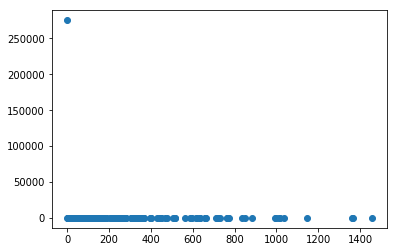

In [73]:
# there are many -1 days exsiting which means dac very close to tfa.
plt.scatter(dt_span.value_counts().index.values, dt_span.value_counts().values)


In [74]:
dt_span.unique()

array([ 465,  731,  475,  764,  279,   -1,  311,  100,    6,  261,  355,
        215, 1368,    5,  162, 1455,  664,  307, 1360,  353,  273,  217,
         75,  348,  850,  994,    1,  997,  153, 1035,  615,  721,  515,
       1010, 1147,   19,  767,   90,  447,   12,    3,  336,  398,  709,
       1017,  327,    0,    2,  310,  240,   77,  717,  303,  258,  302,
         61,  657,  837,  166,  506,  238,  400,  282,  881,  635,   36,
        450,   15,  564,  633,  357,  136,  313,   94,  773,  168,   30,
        203,  762,  586,   39,   56,  124,  123,   46,  175,  658,  594,
        513,   17,   43,   85,  430,  128,  321,  621,  233,   79,    4,
        137,   64,   28,  394,   91,  152,   10,  437,  102,  366,  368,
        446,  363,  132,  209,  361,  236,  117,  248,   16,  142,  115,
        107,  228,  330,   73,  149,  145,  358,  188,  257,    8,  103,
         45,  178,    9,  131,  245,  242,   34,   20,  105,  110,  143], dtype=int64)

In [75]:
# create categorical feature: span = -1 (=one day); -1 < span < 30(=one month); 31 < span < 365 (=one year); span > 365 (=other)
def get_span(dt):
    # dt is an integer
    if dt == -1:
        return 'OneDay'
    elif (dt < 30) & (dt > -1):
        return 'OneMonth'
    elif (dt >= 30) & (dt <= 365):
        return 'OneYear'
    else:
        return 'other'

In [76]:
# Again, one hot encoding 
df['dt_span'] = np.array([get_span(x) for x in dt_span])
df_dt_span = pd.get_dummies(df.dt_span, prefix = 'dt_span')
df = pd.concat((df, df_dt_span), axis = 1)
df.drop(['dt_span'], axis = 1, inplace = True)
df.head()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,dac_wd_6,dac_wd_7,dac_season_0,dac_season_1,dac_season_2,dac_season_3,dt_span_OneDay,dt_span_OneMonth,dt_span_OneYear,dt_span_other
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,NaN,facebook,0,en,direct,direct,...,0,0,0,0,1,0,0,0,0,1
1,820tgsjxq7,2011-05-25,20090523174809,MALE,38.0,facebook,0,en,seo,google,...,0,0,0,1,0,0,0,0,0,1
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,56.0,basic,3,en,direct,direct,...,0,0,0,0,0,1,0,0,0,1
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,42.0,facebook,0,en,direct,direct,...,0,0,0,0,0,1,0,0,0,1
4,87mebub9p4,2010-09-14,20091208061105,-unknown-,41.0,basic,0,en,direct,direct,...,0,0,0,0,1,0,0,0,1,0


In [77]:
# drop the time feature after feature engineering
df.drop(['date_account_created','timestamp_first_active'], axis = 1, inplace = True)

In [78]:
df.columns

Index(['id', 'gender', 'age', 'signup_method', 'signup_flow', 'language',
       'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked',
       'signup_app', 'first_device_type', 'first_browser', 'tfa_year',
       'tfa_month', 'tfa_day', 'tfa_wd_1', 'tfa_wd_2', 'tfa_wd_3', 'tfa_wd_4',
       'tfa_wd_5', 'tfa_wd_6', 'tfa_wd_7', 'tfa_season_0', 'tfa_season_1',
       'tfa_season_2', 'tfa_season_3', 'dac_year', 'dac_month', 'dac_day',
       'dac_wd_1', 'dac_wd_2', 'dac_wd_3', 'dac_wd_4', 'dac_wd_5', 'dac_wd_6',
       'dac_wd_7', 'dac_season_0', 'dac_season_1', 'dac_season_2',
       'dac_season_3', 'dt_span_OneDay', 'dt_span_OneMonth', 'dt_span_OneYear',
       'dt_span_other'],
      dtype='object')

### 2. Clean Age Data

In [173]:
#Age
#1. Deal with Outlier (Keeping ages in 14 < age < 99 as OK and grouping others according different kinds of mistakes)
av = df.age.values
# e.g. Assume people who put age between 1990 and 2000 are the people who put Birth year instead of Age. Then use current year(back then it is 2014) minus "age"
av = np.where(np.logical_and(av<2000, av>1900), 2014-av, av) #This are birthdays instead of age (estimating age by doing 2014 - value)
############# you can feel free to make other assumptions and treat data as below ##########################
#av = np.where(np.logical_and(av<14, av>0), 4, av) #Using specific value=4 for age values below 14
#av = np.where(np.logical_and(av<2016, av>2010), 9, av) #This is the current year insted of age (using specific value = 9)
#av = np.where(av > 99, 110, av)  #Using specific value=110 for age values above 99
###########################

In [174]:
df['age']= av
#Note: df['xxx'] and df.xxx can be used interchangeably

In [175]:
#2. Put ages to different categories and use one hot encoding to normalize categories
age = df.age

In [177]:
age.fillna(-1, inplace = True) # inplace=True can affect original df.age
df.age.head(10)

0    -1.0
1    38.0
2    56.0
3    42.0
4    41.0
5    -1.0
6    46.0
7    47.0
8    50.0
9    46.0
Name: age, dtype: float64

In [82]:
div = 15

def get_age(age):
    # age is a float number, put them to different categories, 15 yrs as an interval
    if age < 0:
        return 'NA'
    elif (age < div): 
        return div
    elif (age <= div * 2):
        return div*2
    elif (age <= div * 3):
        return div * 3
    elif (age <= div * 4):
        return div * 4
    elif (age <= div * 5):
        return div * 5
    elif (age <= 110):
        return div * 6
    else:
        return 'Unphysical'
        

In [181]:
# create age categorical features:
df.age= np.array([get_age(x) for x in age])
df.age.head(10)

0    NA
1    45
2    60
3    45
4    45
5    NA
6    60
7    60
8    60
9    60
Name: age, dtype: object

In [197]:
# one hot encoding 
df_age_onehot = pd.get_dummies(df.age, prefix = 'age')
df_age_onehot.head()

AttributeError: 'DataFrame' object has no attribute 'age'

In [185]:
df = pd.concat((df, df_age_onehot), axis = 1)
df.drop(['age'], axis = 1, inplace = True)
df.head()

,id,date_account_created,timestamp_first_active,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,...,age_NA,age_Unphysical,age_15,age_30,age_45,age_60,age_75,age_90,age_NA,age_Unphysical
0,gxn3p5htnn,2010-06-28,20090319043255,-unknown-,facebook,0,en,direct,direct,untracked,...,1,0,0,0,0,0,0,0,1,0
1,820tgsjxq7,2011-05-25,20090523174809,MALE,facebook,0,en,seo,google,untracked,...,0,0,0,0,1,0,0,0,0,0
2,4ft3gnwmtx,2010-09-28,20090609231247,FEMALE,basic,3,en,direct,direct,untracked,...,0,0,0,0,0,1,0,0,0,0
3,bjjt8pjhuk,2011-12-05,20091031060129,FEMALE,facebook,0,en,direct,direct,untracked,...,0,0,0,0,1,0,0,0,0,0
4,87mebub9p4,2010-09-14,20091208061105,-unknown-,basic,0,en,direct,direct,untracked,...,0,0,0,0,1,0,0,0,0,0


In [187]:
df.shape # 39 features right now

(275547, 39)

### 3. One Hot Encoding for all of the rest categorical features

In [188]:
# pay attention to the 'first_affiliate_tracked' when OHE since this one has missing values. 

feat_toOHE = ['gender', 
             'signup_method', 
             'signup_flow', 
             'language', 
             'affiliate_channel', 
             'affiliate_provider', 
             'first_affiliate_tracked', 
             'signup_app', 
             'first_device_type', 
             'first_browser']

In [189]:
for f in feat_toOHE:
    df_ohe = pd.get_dummies(df[f], prefix=f, dummy_na=True)
    df.drop([f], axis = 1, inplace = True)
    df = pd.concat((df, df_ohe), axis = 1)

In [190]:
df.shape # now we have 192 features

(275547, 192)

In [89]:
df.head()

,id,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,...,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser,first_browser_nan
0,gxn3p5htnn,2009,3,19,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,820tgsjxq7,2009,5,23,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,4ft3gnwmtx,2009,6,9,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,bjjt8pjhuk,2009,10,31,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,87mebub9p4,2009,12,8,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Feature engineering completed at this stage

## Merge Training/Testing dataset with Session dataset

In [191]:
df_all = pd.merge(df, df_agg_sess, how='left') # The common column between session and traing/test dataset is ID. So they will be merged based on ID
df_all = df_all.drop(['id'], axis=1)

In [196]:
# Note: from previous, we know there are 15588 IDs in Session dataset; But 275547 IDs in traing/test dataset; 
# We merged on left(i.e. train/test dataset), so there must be 275547-15588=259959 IDs that does not have session data. 
# As shown below(259959 Nulls for each features coming from session dataset). They are Null values

In [195]:
df_all.isnull().sum()

date_account_created           0
timestamp_first_active         0
tfa_year                       0
tfa_month                      0
tfa_day                        0
tfa_wd_1                       0
tfa_wd_2                       0
tfa_wd_3                       0
tfa_wd_4                       0
tfa_wd_5                       0
tfa_wd_6                       0
tfa_wd_7                       0
age_15                         0
age_30                         0
age_45                         0
age_60                         0
age_75                         0
age_90                         0
age_NA                         0
age_Unphysical                 0
age_15                         0
age_30                         0
age_45                         0
age_60                         0
age_75                         0
age_90                         0
age_NA                         0
age_Unphysical                 0
gender_-unknown-               0
gender_FEMALE                  0
          

In [90]:
df_all = df_all.fillna(-2)  #Missing features for samples without sesssion data.

#All types of null 
df_all['all_null'] = np.array([sum(r<0) for r in df_all.values]) # how many null features for each ID(row) in merged dataset
# IF ID is in training/test dataset but not in session dataset, then value should be 293(see below) which makes sense,
# since #features of session dataset=294, when we dropped ID feature, it is 293

In [91]:
df_all.head(10)

,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7,...,c_284,c_285,c_286,c_287,c_288,c_289,c_290,c_291,c_292,all_null
0,2009,3,19,0,0,0,1,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,293
1,2009,5,23,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,293
2,2009,6,9,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,293
3,2009,10,31,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,293
4,2009,12,8,0,1,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,293
5,2010,1,1,0,0,0,0,1,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,293
6,2010,1,2,0,0,0,0,0,1,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,293
7,2010,1,3,0,0,0,0,0,0,1,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,293
8,2010,1,4,1,0,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,293
9,2010,1,4,1,0,0,0,0,0,0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,293


In [92]:
df_all.shape # 275547 IDs, 497 total features

(275547, 497)

# split the train and test dataset now

In [93]:
# train_row is the numbers of ROWS in training set we recorded earlier. 

Xtrain = df_all.iloc[:train_row, :] # using indexing sliding to extract
Xtest = df_all.iloc[train_row:, :]

# convert the labels to numerical values (label is destination countries- i.e. outcome-- defined at beginning (just search "label"))
le = LabelEncoder() # labelencoder imported from sklearn package
le.fit(labels)
ytrain = le.transform(labels) # use label encoder to transform destination countries to numerical values for modelling to use. 

print (ytrain)

[ 7  7 10 ...,  7  7  7]


In [94]:
# make sure we did not loss rows(IDs) after cleaning data for both training and test dataaset
print (train.shape[0] == Xtrain.shape[0]) 
print (test.shape[0] == Xtest.shape[0])

True
True


In [95]:
# SAVEING FILES
Xtrain.to_csv("Airbnb_xtrain_v2.csv")
Xtest.to_csv("Airbnb_xtest_v2.csv")
labels.tofile("Airbnb_ytrain_v2.csv", sep='\n', format='%s')